# Fiddler Model Monitoring

## Online Travel Agency - Optimizing User Search Experiences 
Consider a leading online travel agency aiming to enhance its hotel ranking model. The travel agency trains the ranking model to predict the likelihood of a hotel being clicked or booked by a specific user. The improved model would consider factors like pricing, location, user reviews, and contextual details such as travel dates and user devices. This allows them to refine their search result rankings, making them more relevant to individual preferences. The net effect is that the traveling agency can increase booking rates, enhance customer satisfaction, and drive revenue growth through a more personalized and efficient search experience.

There are 2 components to this travel agency scenario:
-  **Search Ranking Model**
    -  This Search Ranking Model provides the user with a list of top-ranked travel experiences.
    -  The model tracks users' propensity to click and book the most relevant experiences.

- **LLM Chatbot Assistant**
    -  This acts as an interface for the user to access the listing and book experiences via the chat interface instead of a manual search.
    -  The chatbot uses the ranked trip options created by the **Search Ranking Model**.


## 0. Install Fiddler and SageMaker client Python modules

Install the Fiddler and SageMaker Python clients to authenticate and onboard models, publish data, and more!

> **IMPORTANT:** If using this Notebook with a live, Fiddler on SageMaker, application, you must use a SageMaker Studio Notebook within the same SageMaker Studio Domain.

In [ ]:
!python -m pip install client/fiddler_client-3.7.0.dev4-py3-none-any.whl client/sagemaker-2.227.1.dev0-py3-none-any.whl tabulate
%load_ext autoreload
%autoreload 2

## 1. Authenticate to Fiddler using SageMaker Auth Provider

1. Click Open on Fiddler in the SageMaker Partner AI Apps Section:

    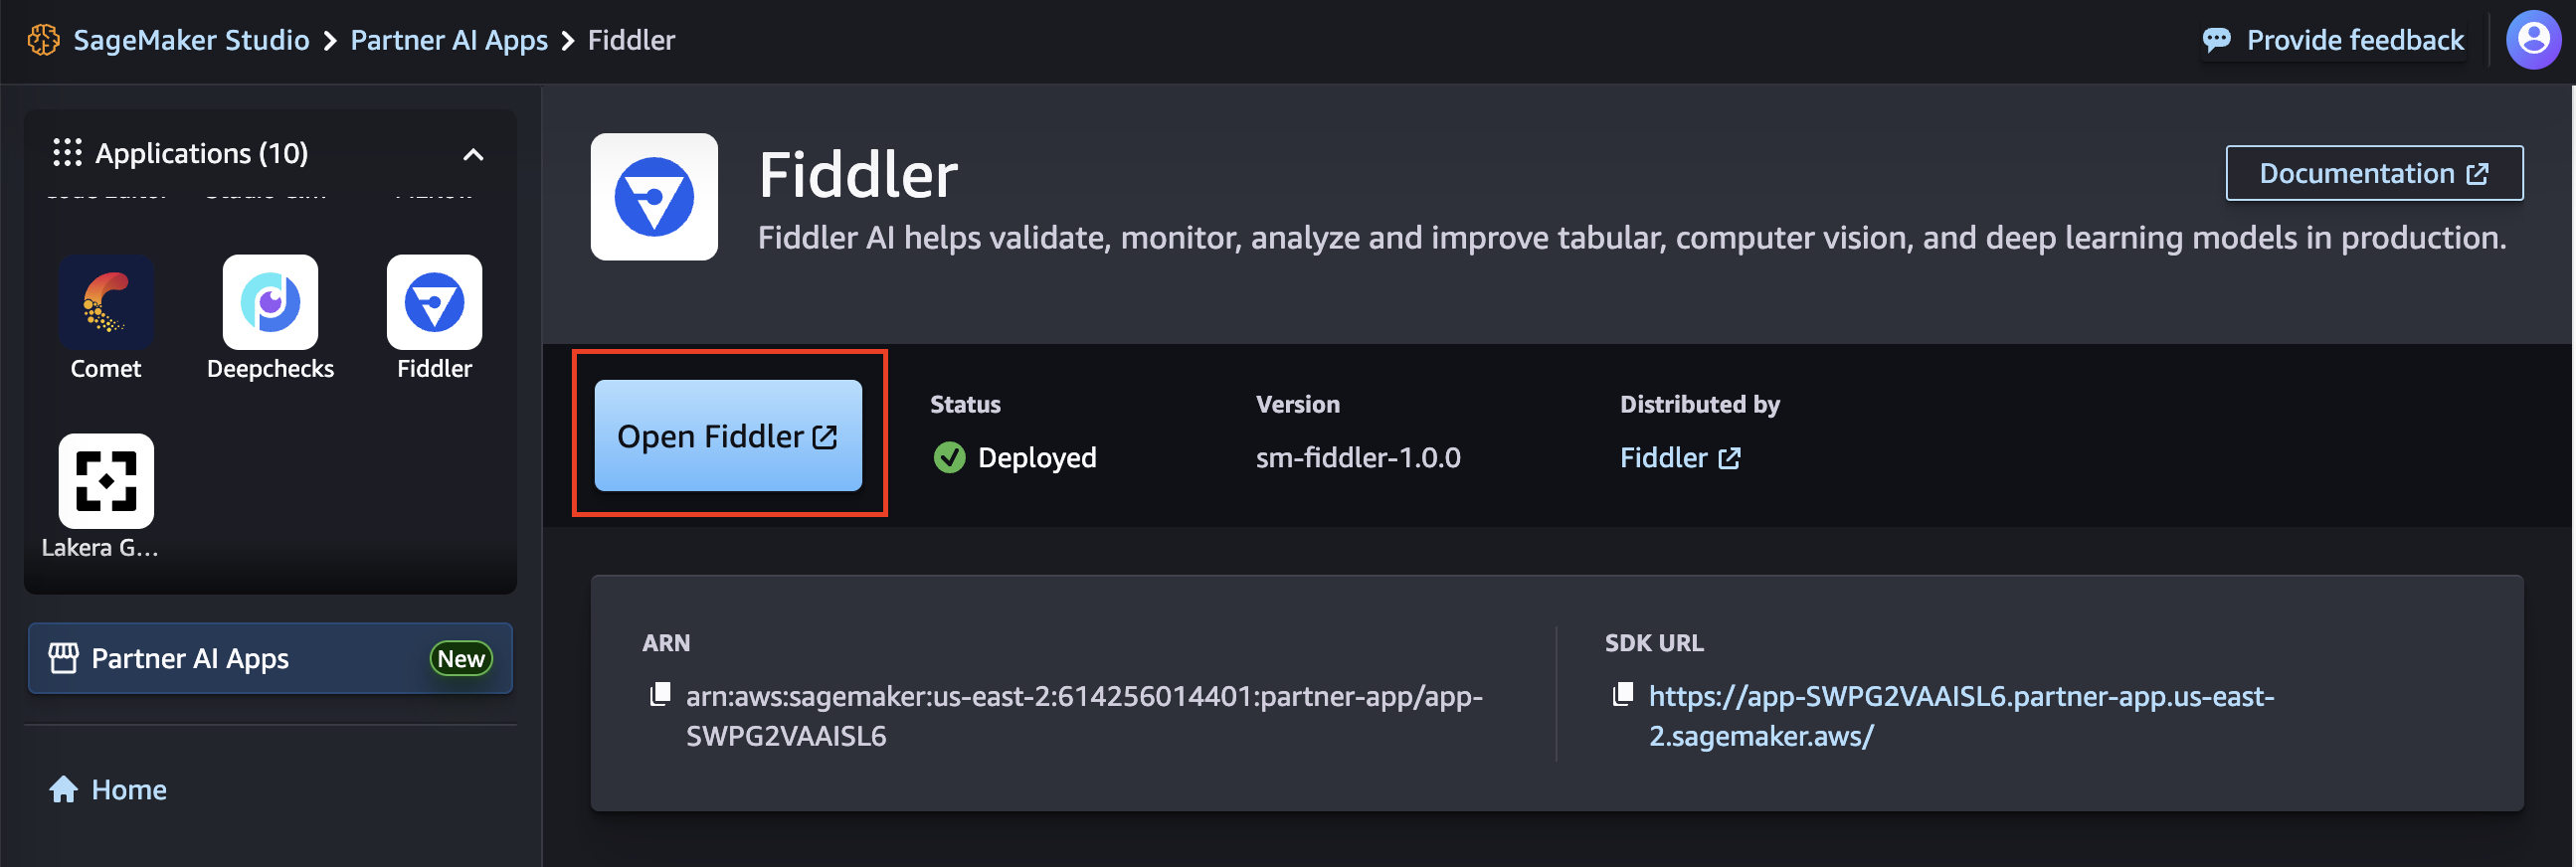

    [<img src="imgs/login_view.png" width="800"/>](./imgs/login_view.png)

1. On the Settings page, click on the Credentials tab.

    [<img src="imgs/settings_view.png" width="800"/>](./imgs/settings_view.png)

1. Finally, copy your token from the credentials list.

    [<img src="imgs/credentials_tab.png" width="800"/>](./imgs/credentials_tab.png)

## <font color='red'>Change the values below before running!</font>

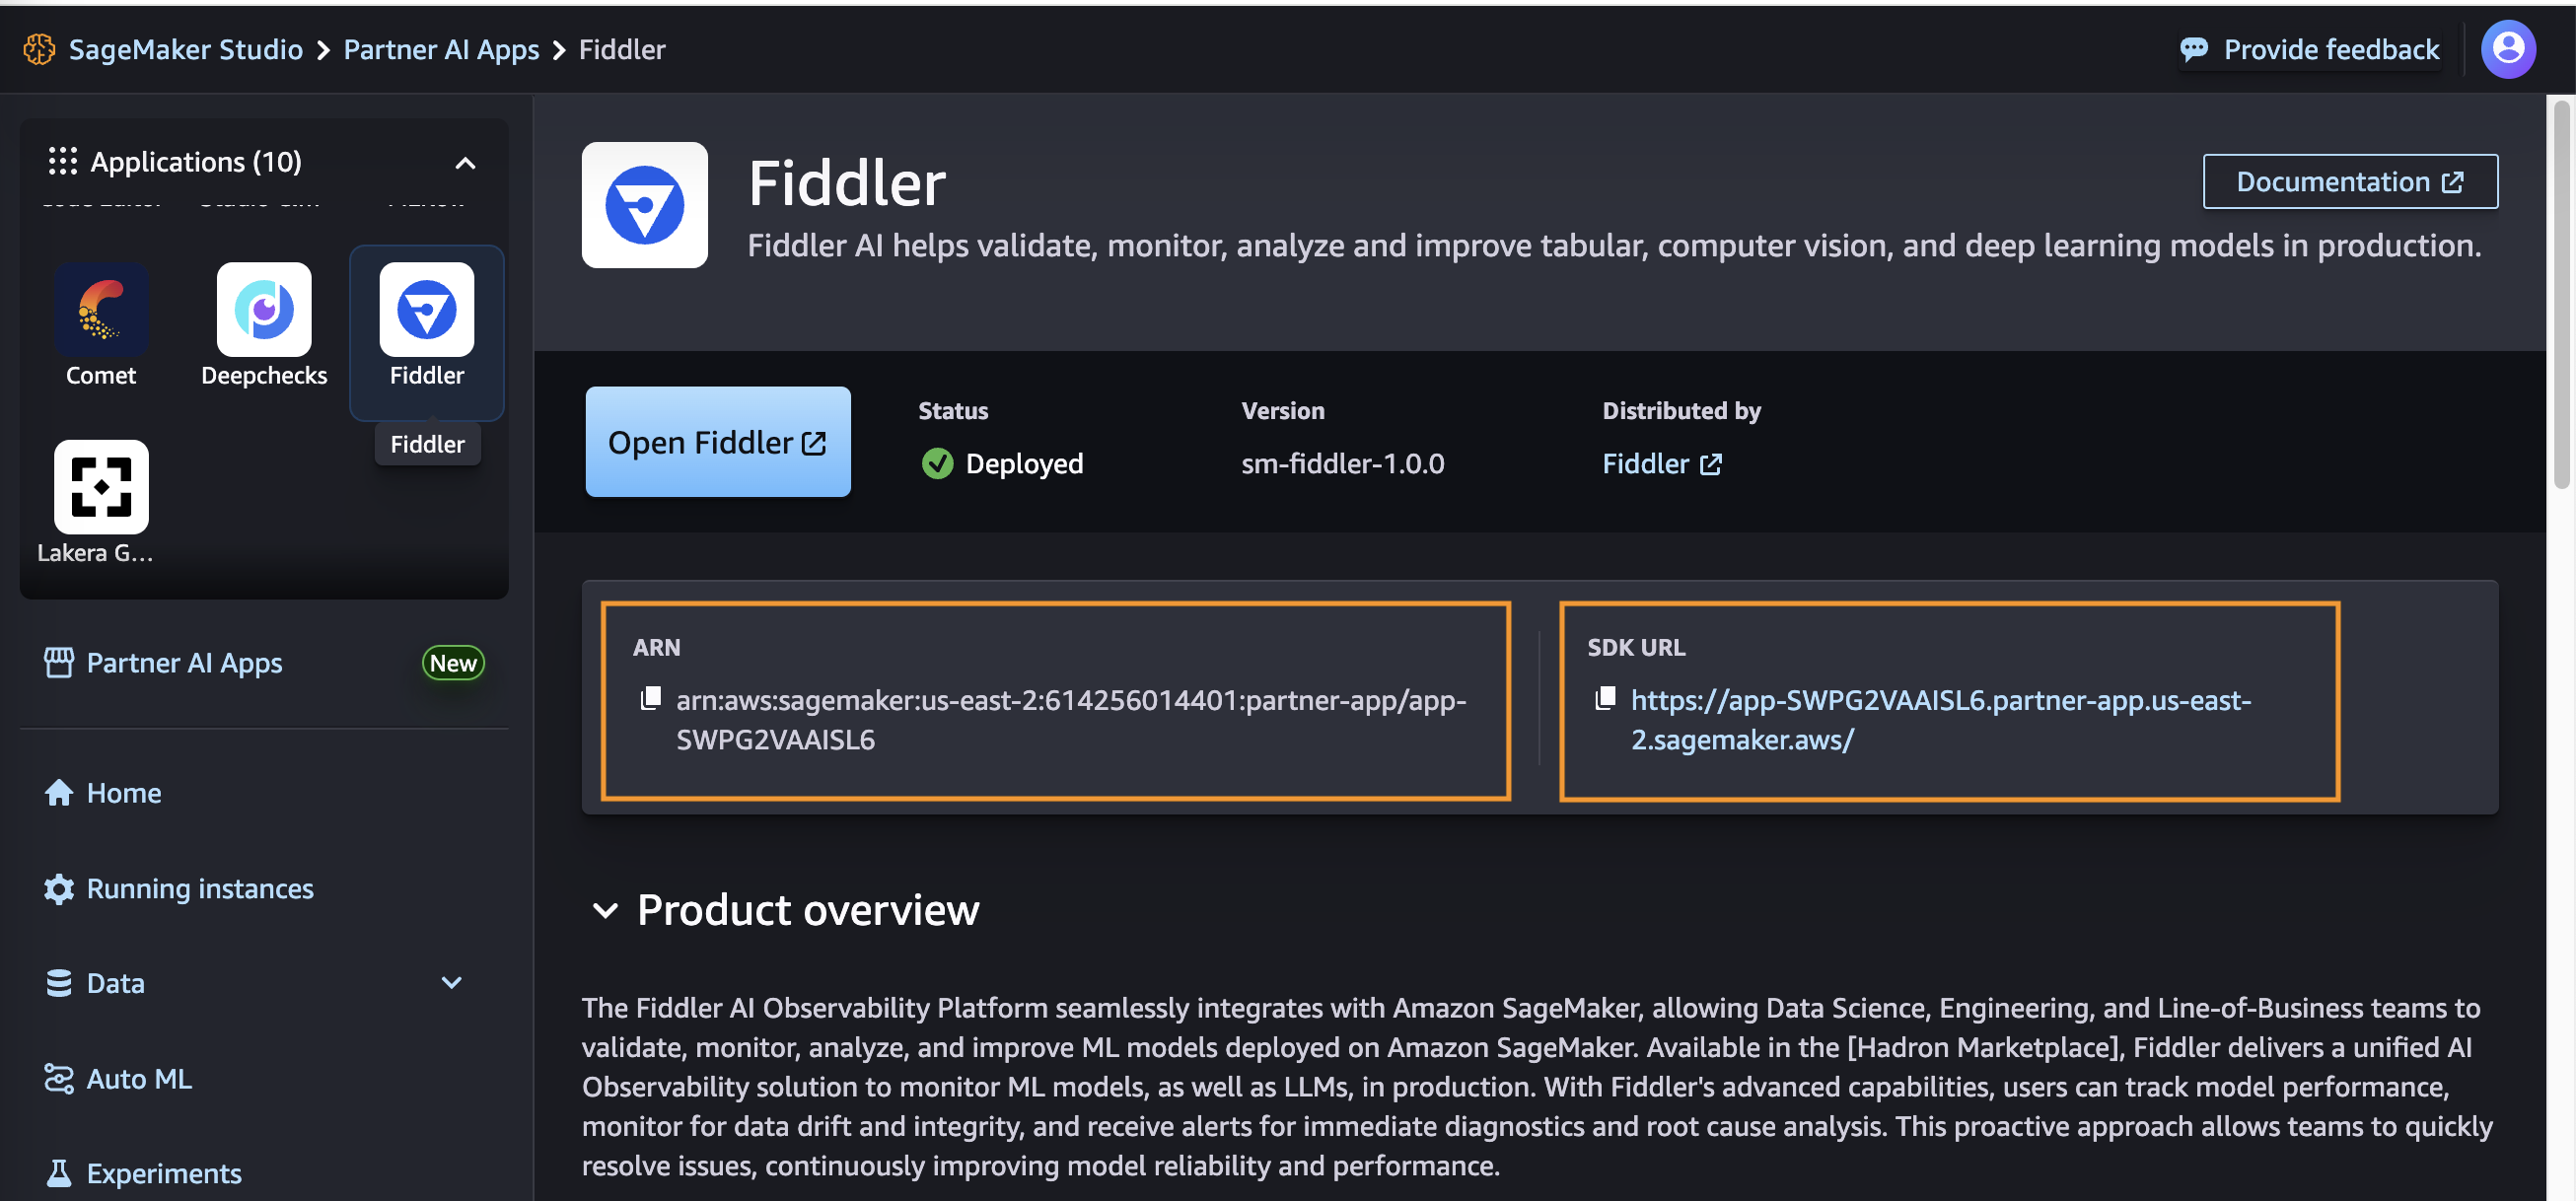

In [ ]:
# For SageMaker Studio -> Partner AI Apps -> Lakera -> View Details

APP_URL = '' # View Details -> SDK URL
APP_ARN = '' # View Details -> ARN
TOKEN = '' # Click Open Fiddler from SageMaker Studio -> Partner AI Apps -> Bottom left corner click on user -> Credentials -> Keys -> Copy Key

UNIQUE_ID = 'jane_doe' # A unique ID to identify your Project

# If something goes wrong in your notebook, you can change the UNIQUE_ID and start over!

In [ ]:
import os 
import pandas as pd
import time

import fiddler as fdl

os.environ['AWS_PARTNER_APP_AUTH'] = 'false'
os.environ['AWS_PARTNER_APP_ARN'] = APP_ARN
os.environ['AWS_PARTNER_APP_URL'] = APP_URL

# Initialize the Fiddler client
fdl.init(url=APP_URL, token=TOKEN)

## 2. Create a Model, Configure Segments, and Publish data!

You are now authenticated to Fiddler running as a SageMaker Partner App! Our Python client is powerful tool for managing your Fiddler app in code. It is required for creating models and publishing baseline and production events.

An **event** is a vector of inputs, the model's inferred outputs, and some metadata pertaining to the Fiddler event being published and the model it's being published to.

The following section of code will perform the following. Don't worry too much about understanding all of this now, this codelab is public!

1.  Create a Project in your Fiddler app called `ai_travel_agent_<UNIQUE_NAME>`.
1.  Load a sample event dataset for the Travel Agency Ranking Model.
1.  Configure the Model specification. This tells Fiddler which columns are the inputs, outputs, targets, and metadata.
1.  Create the Model in your Project.

In [ ]:
from modules.config import *

# Generate a unique project name
PROJECT_NAME = append_unique_name(PROJECT_NAME_PREFIX, UNIQUE_ID)

# Create the Project or find it by name
project = None
try:
    # Create project
    project = fdl.Project(name=PROJECT_NAME).create()
    print(f'New project created with id = {project.id} and name = {project.name}')
except fdl.Conflict:
    # Get project by name if it exists
    project = fdl.Project.from_name(name=PROJECT_NAME)
    print(f'Loaded existing project with id = {project.id} and name = {project.name}')

In [ ]:
# Load a sample data set from the Search Ranking Model
sample_data_df = pd.read_csv(PATH_TO_SAMPLE_RANKING_CSV)

timestamp_column = 'timestamp'

# Define the Model Task Type
model_task = fdl.ModelTask.RANKING
task_params = fdl.ModelTaskParams(
    group_by='search_id', top_k=20, target_class_order=[0, 1]
)

# Tell Fiddler which columns are inputs, outputs, targetsm 
model_spec = fdl.ModelSpec(
    inputs=list(
        sample_data_df.drop(
            columns=[
                'user_interaction',
                'output_score',
                'grad_rel',
                'position',
                'timestamp',
            ]
        ).columns
    ),
    outputs=['output_score'],
    targets=['user_interaction'],
    metadata=['timestamp', 'grad_rel', 'position'],
)


# Create or load the Model
ranking_model = None
try:
    # Create model
    ranking_model = fdl.Model.from_data(
        name=RANKING_MODEL_NAME,
        project_id=project.id,
        source=sample_data_df,
        spec=model_spec,
        task=model_task,
        task_params=task_params,
        event_ts_col=timestamp_column,
    )
    ranking_model.create()
except fdl.Conflict:
    ranking_model = fdl.Model.from_name(
        name=RANKING_MODEL_NAME,
        project_id=project.id,
    )

print(f'Travel listing ranking registered model with id = {ranking_model.id} and name = {ranking_model.name}')
print('Printing sample dataset...')
print(sample_data_df.head(10).to_markdown())

## 3. Create Data Segments

A **segment** represents a distinct subset of model values crucial for performance analysis and troubleshooting. You will define a set of conditions for the ranking model which we will visualize later on.

In this snippet, we are creating segments that will help visualize the ranking model's inferences on destination countries in `prop_countries_list` by source countries in `customer_countries_list`. It also creates segments to visualize whether a user clicked on this promotion.

With these tools, we may observe powerful analytics to answer questions such as "How do users in Brazil, compare to the UK, click on the ranking model's promoted trip suggestions to Japan and Canada?"

In [ ]:
from modules.ml_onboard import create_country_segments

prop_countries_list = ['USA', 'Japan', 'UK', 'Canada', 'Mexico']
customer_countries_list = [
    'USA',
    'Japan',
    'UK',
    'Canada',
    'Mexico',
    'Brazil',
    'China',
    'India',
    'South Africa',
    'France',
]
create_country_segments(ranking_model.id, customer_countries_list, prop_countries_list)

## 4. Publish Production Model Data

Now that we've defined segments on which to analyze the data, let's load and publish some production events. `model.publish()` is going to kick off asyncronous data ingestion jobs.

Data ingestion is an important, core, workflow in Fiddler. The Fiddler Python client you are using in this notebook may stream data or kick off batch ingestion jobs. One powerful example would be triggering an AWS Lambda Function when Parquet objects are created in an S3 bucket to publish the data to Fiddler.

These jobs should take just a few seconds to finish. Please continue to step 5 to perform similar tasks for an LLM model. Note, you will be sharing an instance with your workshop cohort, so you will see several more jobs than just your own in the UI!

In [ ]:
production_data_df = pd.read_csv(PATH_TO_EVENTS_RANKING_CSV)

# Shift the timestamps of the production events to be as recent as today
production_data_df['timestamp'] = production_data_df['timestamp'] + (
    int(time.time()) - production_data_df['timestamp'].max()
)

df_logs_grouped = fdl.utils.helpers.group_by(
    df=production_data_df, group_by_col='search_id'
)

# Publish production event data
production_publish_job = ranking_model.publish(df_logs_grouped)
ml_job_id = production_publish_job.id

print(
    f'Initiated production environment data upload with Job ID = {production_publish_job.id}'
)

## 5. Repeat Model Onboarding and Event Publication for an LLM

The steps for creating the LLM model are similar to the above steps with some differences as to how we define the model type, specification, and segments by which we'd like to analyze the model.

In [ ]:
from modules.llm_onboard import create_and_publish_llm

llm_model, llm_job_id = create_and_publish_llm(project, LLM_MODEL_NAME)
print(
    f'Initiated production environment data upload with Job ID = {llm_job_id}'
)

## 6. Create Charts to Visualize Model Segments



In [ ]:
from modules.chart import add_charts

errors = add_charts(project, ranking_model, UNIQUE_ID, PATH_TO_ML_CHARTS, APP_URL, TOKEN)
errors = add_charts(project, llm_model, UNIQUE_ID, PATH_TO_LLM_CHARTS, APP_URL, TOKEN)

## 7. Build a Custom Dashboard for Model Performance Insights

1.  Navigate to the dashboard page (a)
1.  Click `Add Dashboard` (b)

    [<img src="imgs/create_dashboard.png" width="800"/>](./imgs/create_dashboard.png)

    1.  Select your project, `ai_travel_assistant_<UNIQUE_ID>`
    1.  Click `Add Chart` > `Saved Charts`
    1.  Add the following charts, prefixed with `[<UNIQUE_NAME>]` according to your input:
        -   Destination Geographical Distribution
        -   Price Effect on Clicks
        -   User Input UMAP
        -   Chatbot Response UMAP
        -   Cost Tracker for Chatbot
        -   Model Performance Segmented by Destination
        -   User Sentiment Tracker
    1. Name, and save your dashboard before moving on.

## 8. Perform Root Cause Analysis

1.  Click on the title-link for the `User Input UMAP` chart
    1.  Pick a cluster within the UMAP
    1.  Try a different `Color by` Label

    [<img src="imgs/root_cause_analysis.png" width="800"/>](./imgs/root_cause_analysis.png)
    
1.  Discard changes and, go back to Dashboards and right-click on a point on the `Price Effect on Click` Chart to open up Root Cause Analysis (RCA)

    [<img src="imgs/rca_init.png" width="800"/>](./imgs/rca_init.png)

    1.  Navigate the `Events` tab to view model data 

    [<img src="imgs/rca_events.png" width="800"/>](./imgs/rca_events.png)

    1.  Check Feature Drift by clicking the `Data Drift` tab
    1.  Select the `default_static_baseline` for the Basline by which to compare the event.
    1.  Now we can visualize the normalized feature drift 

    [<img src="imgs/rca_drift.png" width="800"/>](./imgs/rca_drift.png)

## 9. Next Steps

To learn more about the AI observability for LLM and MLOps Fiddler can offer please check our product tours here: [Product Tour: Fiddler AI Observability for LLM Applications and ML Models](https://www.youtube.com/watch?v=sNppVfEcaGo&list=PL9ekywqME2AjEb-6JHjYhqT_S5bY6Di4n&index=2)

You can purchase and get access to the Fiddler AI Observability platform within the Amazon SageMaker Studio. 